## Imports

In [419]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [420]:
data = pd.read_csv('../data/processed_trips_2018.csv')
stations = pd.read_csv('../data/processed_stations_2018.csv')

In [421]:
stations.groupby('station_id').size().reset_index(name='counts').sort_values(by='counts', ascending=False).head(5)

,station_id,counts
268,530.0,2
0,72.0,1
570,3388.0,1
560,3376.0,1
561,3377.0,1


In [422]:
stations['station_latitude'] = stations['station_latitude'].round(4)
stations['station_longitude'] = stations['station_longitude'].round(4)
stations = stations.drop_duplicates(subset=['station_id', 'station_latitude', 'station_longitude'])

Text(0, 0.5, 'Latitude')

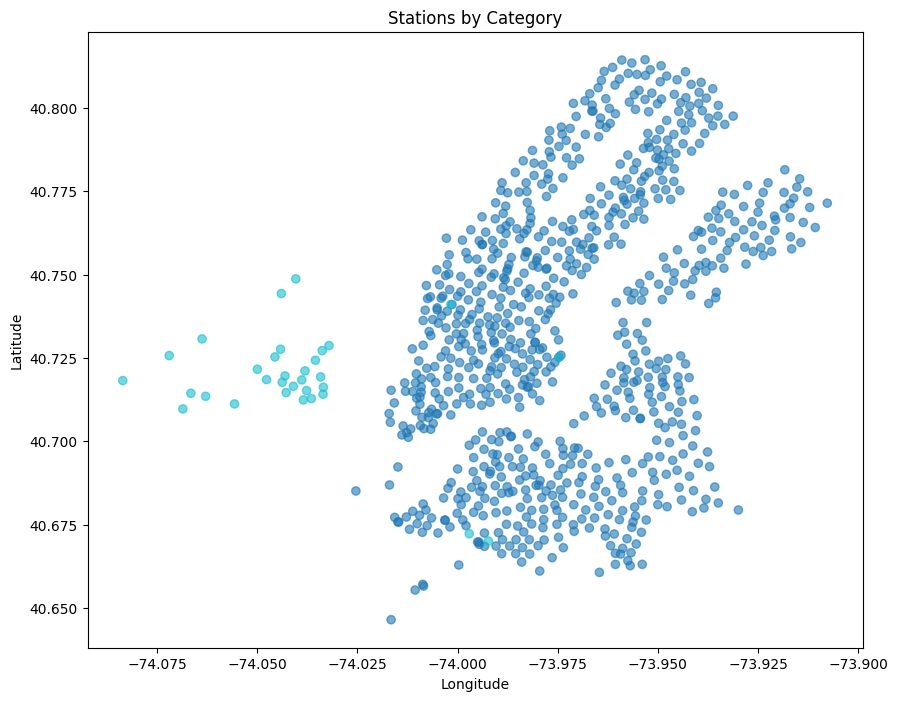

In [423]:
categories = stations['category'].astype('category')
colors = categories.cat.codes  
fig = plt.figure(figsize=(10, 8))
plt.scatter(
    stations['station_longitude'],
    stations['station_latitude'],
    c=colors,
    cmap='tab10',     
    alpha=0.6
)

plt.title('Stations by Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


## Clustering

### Elbow method

In [424]:
def elbow_method(data, max_k):
    sse = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    return sse
sse = elbow_method(stations[['station_longitude', 'station_latitude']], 30)

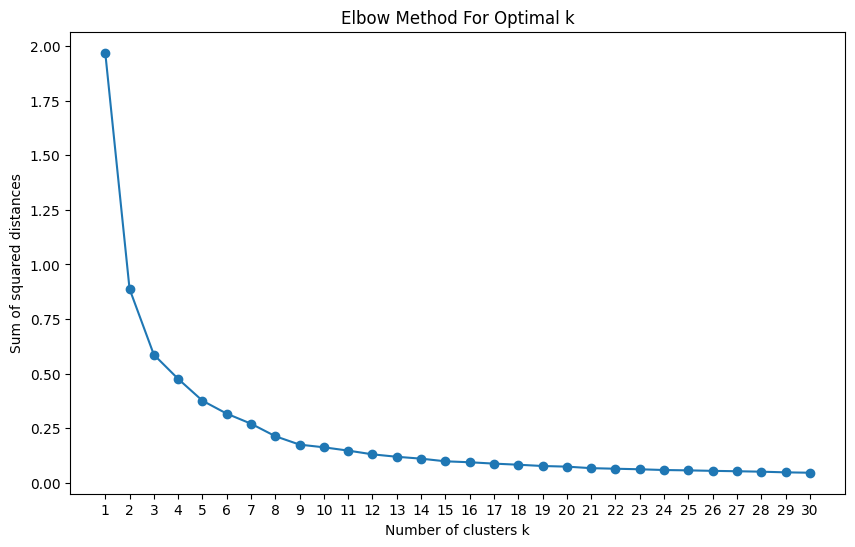

In [425]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distances')
plt.xticks(range(1, 31))
plt.show()

In [426]:
kmeans = KMeans(n_clusters=26)
kmeans.fit(stations[['station_latitude', 'station_longitude']])
stations['station_cluster'] = kmeans.labels_+1

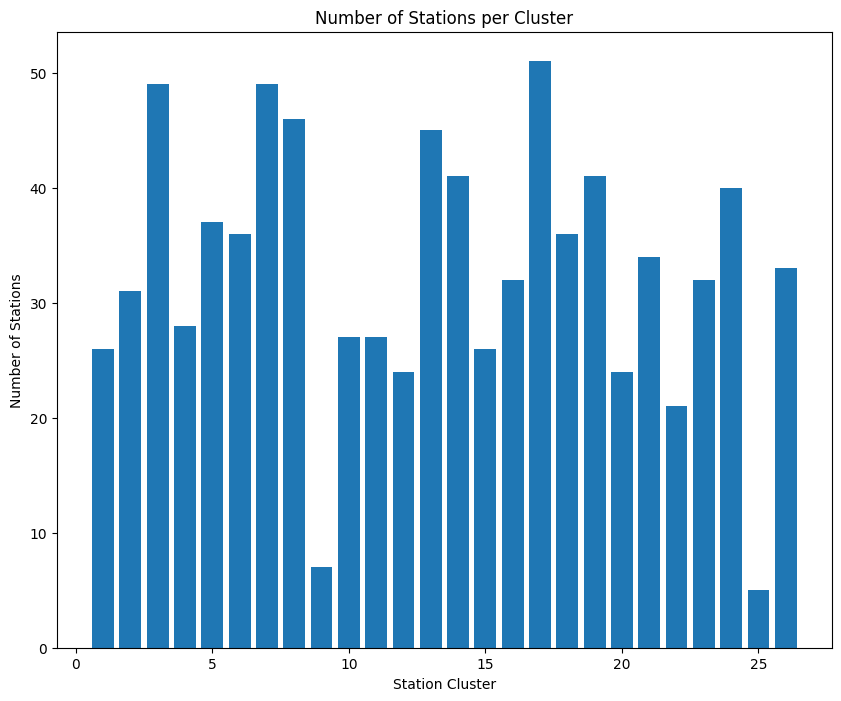

In [427]:
sizes=stations.groupby('station_cluster').size()
fig = plt.figure(figsize=(10, 8))
plt.bar(sizes.index, sizes.values)
plt.xlabel('Station Cluster')
plt.ylabel('Number of Stations')
plt.title('Number of Stations per Cluster')
plt.show()

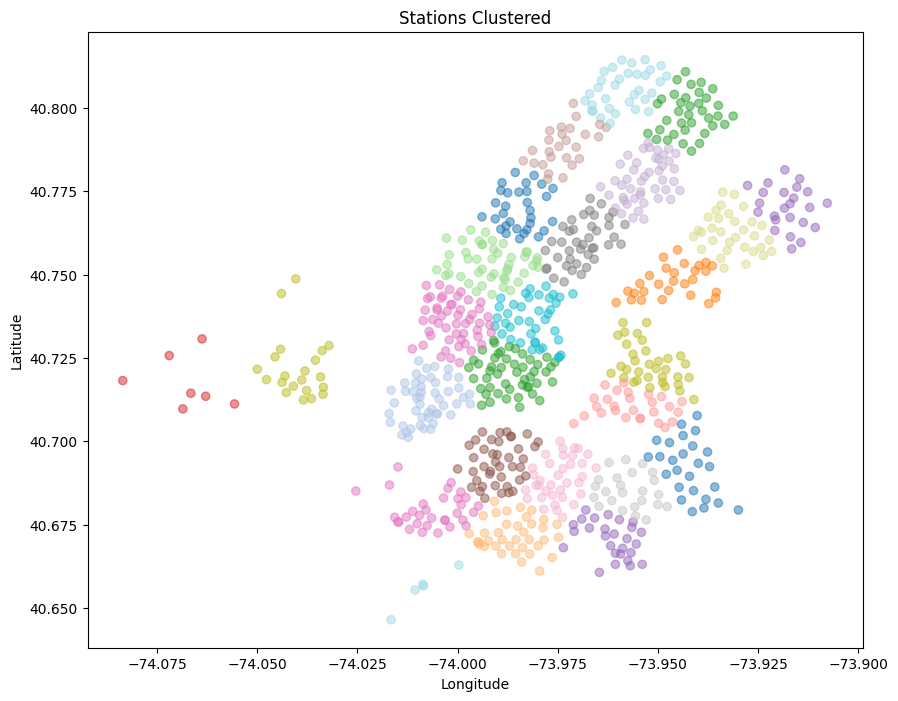

In [428]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(stations['station_longitude'], stations['station_latitude'], c=stations['station_cluster'], cmap='tab20', alpha=0.5)
plt.title('Stations Clustered')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [429]:
data["station_cluster"] = data["start_station_id"].map(stations.set_index("station_id")["station_cluster"])

### Check how many bikes on average per hour per cluster

In [430]:
bikes_per_day = data.groupby(['station_cluster', 'pickup_day', 'pickup_hour']).size().reset_index(name='num_rentals')
avg_bikes_per_cluster = bikes_per_day.groupby('station_cluster')['num_rentals'].mean().reset_index(name='avg_num_rentals')


In [431]:
avg_bikes_per_cluster.sort_values(by='avg_num_rentals', ascending=False)

,station_cluster,avg_num_rentals
15,17,256.924249
7,8,240.810832
21,24,207.403398
6,7,196.804696
2,3,177.917935
17,19,155.052033
1,2,146.092539
12,14,81.142153
11,13,73.872744
13,15,70.966829


In [432]:
cluster = data[data['station_cluster'] == avg_bikes_per_cluster.iloc[0]['station_cluster']]

In [433]:
hourly_pickups_cluster = cluster.groupby(['pickup_datetime', 'pickup_day', 'pickup_hour'])['bikeid'].size().reset_index(name='num_rentals')
hourly_dropoffs_cluster = cluster.groupby(['dropoff_datetime', 'dropoff_day', 'dropoff_hour'])['bikeid'].size().reset_index(name='num_rentals')

In [434]:
hourly_pickups_cluster

,pickup_datetime,pickup_day,pickup_hour,num_rentals
0,2018-01-01 00:00:00,2018-01-01,0,2
1,2018-01-01 01:00:00,2018-01-01,1,1
2,2018-01-01 02:00:00,2018-01-01,2,1
3,2018-01-01 03:00:00,2018-01-01,3,4
4,2018-01-01 08:00:00,2018-01-01,8,1
...,...,...,...,...
8185,2018-12-31 19:00:00,2018-12-31,19,1
8186,2018-12-31 20:00:00,2018-12-31,20,4
8187,2018-12-31 21:00:00,2018-12-31,21,1
8188,2018-12-31 22:00:00,2018-12-31,22,1


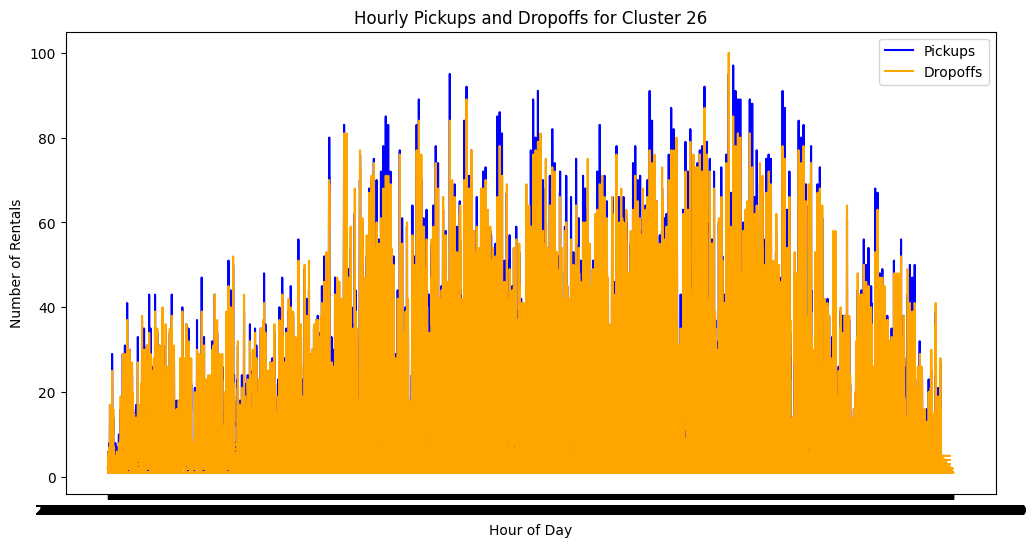

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(hourly_pickups_cluster['pickup_datetime'], hourly_pickups_cluster['num_rentals'], label='Pickups', color='blue')
plt.plot(hourly_dropoffs_cluster['dropoff_datetime'], hourly_dropoffs_cluster['num_rentals'], label='Dropoffs', color='orange')
plt.title('Hourly Pickups and Dropoffs for Cluster 26')
plt.ylabel('Number of Rentals')
plt.legend()
plt.show()

In [436]:
print(f'size of hourly_pickups_cluster: {hourly_pickups_cluster.shape}')
def fill_missing_hours(df):
    all_hours = pd.date_range(start=df['pickup_day'].min(), end=df['pickup_day'].max(), freq='H')
    all_hours_df = pd.DataFrame({'pickup_day': all_hours.date, 'pickup_hour': all_hours.hour})
    all_hours_df["pickup_day"] = pd.to_datetime(all_hours_df["pickup_day"])
    hourly_pickups_cluster["pickup_day"] = pd.to_datetime(hourly_pickups_cluster["pickup_day"])
    merged_df = pd.merge(all_hours_df, df, on=['pickup_day', 'pickup_hour'], how='left')
    merged_df['num_rentals'] = merged_df['num_rentals'].fillna(0).astype(int)
    return merged_df

hourly_pickups_cluster = fill_missing_hours(hourly_pickups_cluster)
print(f'size of hourly_pickups_cluster after filling missing hours: {hourly_pickups_cluster.shape}')

size of hourly_pickups_cluster: (8190, 4)
size of hourly_pickups_cluster after filling missing hours: (8737, 4)


## Train Time Series

In [437]:
##CONSTANTS
END_TRAINING_DATE = pd.to_datetime("2018-10-31")

## Split train- test

In [438]:
train_data = hourly_pickups_cluster[hourly_pickups_cluster['pickup_day'] <= END_TRAINING_DATE]
test_data = hourly_pickups_cluster[hourly_pickups_cluster['pickup_day'] > END_TRAINING_DATE]
train_data = train_data.set_index('pickup_day')
test_data  = test_data.set_index('pickup_day')
train_data.index = pd.to_datetime(train_data.index)
test_data.index  = pd.to_datetime(test_data.index)

In [439]:
x_train = train_data.drop(columns=['num_rentals'])
y_train = train_data['num_rentals']

x_test = test_data.drop(columns=['num_rentals'])
y_test = test_data['num_rentals']


In [440]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data['num_rentals'], order=(24, 0, 0))
model_fit = model.fit()
print(model_fit.summary())

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            num_rentals   No. Observations:                 7296
Model:                ARIMA(24, 0, 0)   Log Likelihood              -25940.333
Date:                Sun, 09 Nov 2025   AIC                          51932.666
Time:                        17:57:56   BIC                          52111.938
Sample:                             0   HQIC                         51994.311
                               - 7296                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.2188      2.469      7.379      0.000      13.379      23.058
ar.L1          0.6723      0.008     80.088      0.000       0.656       0.689
ar.L2         -0.0764      0.011     -6.836      0.0

In [441]:
n_steps = len(test_data)
predictions = model_fit.forecast(steps=n_steps)
test_data['predicted_num_rentals'] = predictions.values


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [445]:
mae = mean_absolute_error(test_data['num_rentals'], test_data['predicted_num_rentals'])
print(f'MAE: {mae}')
mse = mean_squared_error(test_data['num_rentals'], test_data['predicted_num_rentals'])
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')  


MAE: 10.583942041834787
RMSE: 12.721882974021474
